In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["denoised_trace", "std_phon_trace", "phonetic_trace"]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

## Import

In [2]:
df = pd.read_csv(DF_PREPROC_FILE)

traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"))


In [3]:
len(traces["denoised_trace"][0])

30135

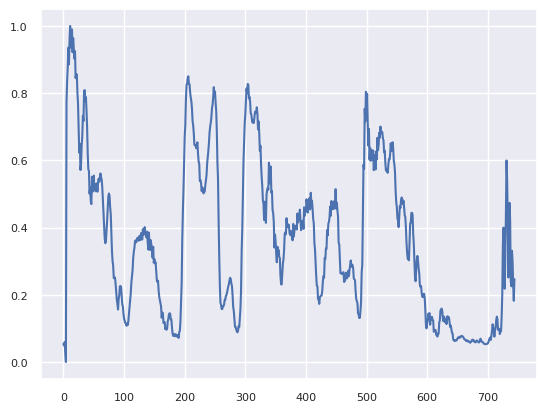

In [4]:
plt.plot(traces["std_phon_trace"][0])

## Metrics

In [5]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [6]:
mat_euclidean = cdist(traces["std_phon_trace"],traces["std_phon_trace"])

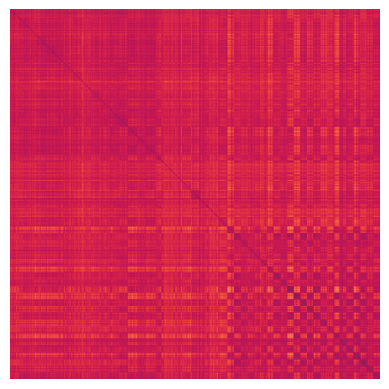

In [7]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

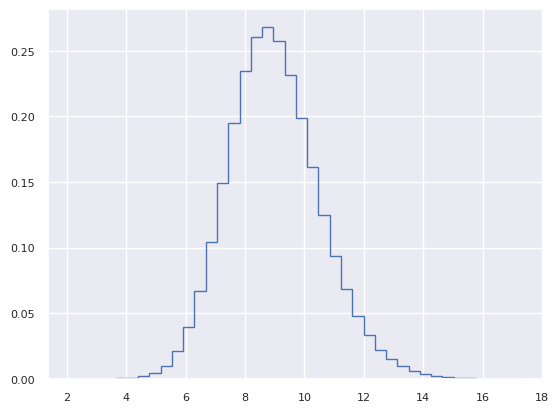

In [8]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);

### Manhattan

In [9]:
mat_manhattan = cdist(traces["std_phon_trace"],traces["std_phon_trace"], metric="cityblock")

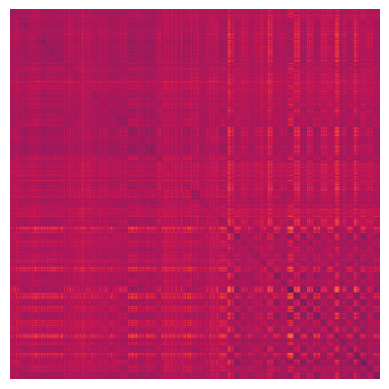

In [10]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

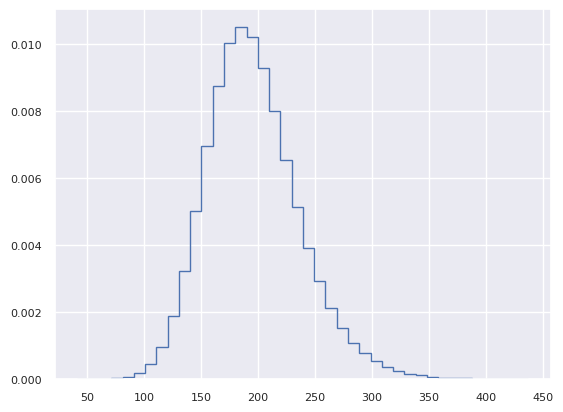

In [11]:
# Distribution of distances
distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [12]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

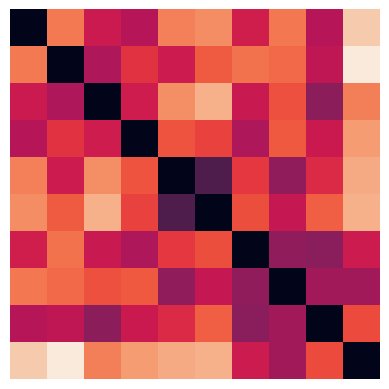

In [13]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


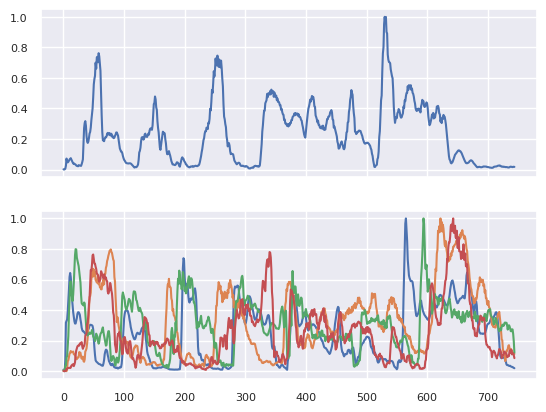

In [14]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(traces["std_phon_trace"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True)

# Plot the requested query
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [15]:
X_train.shape

(2206, 745)

## Kmeans

### Euclidean

53.102 --> 33.140 --> 32.190 --> 31.893 --> 31.787 --> 31.751 --> 31.733 --> 31.729 --> 31.726 --> 31.724 --> 31.721 --> 31.720 --> 31.719 --> 31.718 --> 31.718 --> 31.717 --> 31.717 --> 


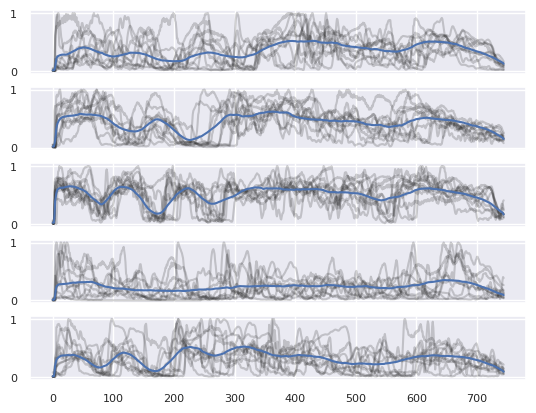

In [16]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 5

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = km.fit_predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])

### DTW

In [ ]:
n_clusters = 5

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

y_pred = km.fit_predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2206 out of 2206 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.4s
[Parallel(n_jobs=

4.250 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.926 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.845 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.808 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.794 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.783 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.777 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.772 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.770 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.768 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.768 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.767 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 11030 out of 

1.766 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   25.6s


In [ ]:
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))